# CHOWDER Method Implementation from [Original Paper](https://arxiv.org/pdf/1802.02212.pdf)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#CHOWDER-Method-Implementation-from-Original-Paper" data-toc-modified-id="CHOWDER-Method-Implementation-from-Original-Paper-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>CHOWDER Method Implementation from <a href="https://arxiv.org/pdf/1802.02212.pdf" target="_blank">Original Paper</a></a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Read-Data" data-toc-modified-id="Read-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Read Data</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train</a></span><ul class="toc-item"><li><span><a href="#Train-k-fold-CV-on-training-set" data-toc-modified-id="Train-k-fold-CV-on-training-set-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Train k-fold CV on training set</a></span></li><li><span><a href="#Plot-train-/-val-CV-loss" data-toc-modified-id="Plot-train-/-val-CV-loss-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Plot train / val CV loss</a></span></li><li><span><a href="#Retrain-ensemble-on-all-training-set" data-toc-modified-id="Retrain-ensemble-on-all-training-set-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Retrain ensemble on all training set</a></span></li></ul></li><li><span><a href="#Predict-test-set" data-toc-modified-id="Predict-test-set-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Predict test set</a></span></li></ul></div>

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import random
import re
import matplotlib.pyplot as plt
%matplotlib notebook

from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
import tensorflow as tf
import keras

print("keras version: ", keras.__version__)
print("tf version: ", tf.__version__)

from keras.layers import *
from keras.models import *
from keras import optimizers 

from MILPooling import MILPooling
from utils import *

keras version:  2.3.1
tf version:  2.1.0


Using TensorFlow backend.


# Parameters

In [2]:
n_ensembles = 10
n_splits = 5
batch_size = 10
lr = 1e-3
epochs = 30
fc_layer_size = [200,100]
dropout_rate = 0.1
R = 5

# Read Data

In [3]:
#data_dir = Path('/media/diana/Shared/OWKIN_data_challenge')
data_dir = Path('../chowder_data')

train_dir = data_dir / "train_input" / "resnet_features"
test_dir = data_dir / "test_input"  / "resnet_features"

train_output_filename = data_dir / "train_output.csv"

df = pd.read_csv(train_output_filename)

# get the filenames for train
filenames_train = sorted(train_dir.glob("*.npy"))
for filename in filenames_train:
    assert filename.is_file(), filename
    
# add paths to df
df['Path'] = filenames_train

In [4]:
# get number of tiles per image and add to DF

def get_number_tiles(filenames):
    n_tiles_per_image = []
    for f in filenames:
        patient_features = np.load(f)
        # Remove location features (but we could use them?)
        patient_features = patient_features[:, 3:]
        n_tiles_per_image.append(patient_features.shape[0])
    return n_tiles_per_image

df['tiles_count'] = get_number_tiles(filenames_train)

In [5]:
df.head(10)

,ID,Target,Path,tiles_count
0,1,0,../chowder_data/train_input/resnet_features/ID...,1000
1,2,0,../chowder_data/train_input/resnet_features/ID...,1000
2,3,0,../chowder_data/train_input/resnet_features/ID...,1000
3,5,0,../chowder_data/train_input/resnet_features/ID...,839
4,6,0,../chowder_data/train_input/resnet_features/ID...,1000
5,7,0,../chowder_data/train_input/resnet_features/ID...,999
6,8,1,../chowder_data/train_input/resnet_features/ID...,1000
7,9,0,../chowder_data/train_input/resnet_features/ID...,1000
8,10,1,../chowder_data/train_input/resnet_features/ID...,442
9,11,0,../chowder_data/train_input/resnet_features/ID...,1000


# Model

In [6]:
def get_model():
    # build model
    input = Input((None, 2048))
    embedding = Conv1D(1,1, activation=None)(input)
    x = MILPooling(kmax=R, kmin=R)(embedding)
    x = Flatten()(x)
    for fc in fc_layer_size:
        x = Dense(fc, activation='sigmoid')(x)
        if dropout_rate > 0:
            x = Dropout(dropout_rate)(x)
    prediction = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input, outputs=prediction)

    # compile model
    model.compile(optimizers.Adam(lr),
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.AUC()])
    return model

In [7]:
get_model().summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 2048)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 1)           2049      
_________________________________________________________________
mil_pooling_1 (MILPooling)   (None, 10, 1)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               2200      
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               2010

# Train

## Train k-fold CV on training set

In [8]:
%%time

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(df.Target.values), y=df.Target.values)
print("class weights", class_weights)

kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

history_folds = []
aucs = []

for fold, (i_train, i_val) in enumerate(kf.split(df, df.Target)):
    print("Fold {} / {}".format(fold+1, n_splits))
    # get train / val DFs
    df_train = df.iloc[i_train]
    df_val = df.iloc[i_val]
    # get train / val batch data generators
    train_generator = batch_generator(df_train, batch_size)
    val_generator = batch_generator(df_val, 1)
    # compute train / val steps
    train_steps = int(np.ceil(len(df_train)/batch_size))
    val_steps = len(df_val)/1
    # get model
    model = get_model()
    # train model
    history = model.fit(
                            train_generator,
                            steps_per_epoch=train_steps,
                            validation_data=val_generator,
                            validation_steps=val_steps,
                            epochs=epochs,
                            verbose=0,
                            class_weight=dict(enumerate(class_weights))
                        )
    # compute and save val AUC
    auc = model.evaluate(val_generator, steps=val_steps)[-1]
    print("Val AUC = {:.3f}".format(auc))
    aucs.append(auc)
    history_folds.append(history.history)
    
aucs = np.array(aucs)
print("***** Val AUC : {:.3f} +/- {:.3f} ***** ".format(aucs.mean(), aucs.std()))

class weights [0.83532934 1.24553571]
Fold 1 / 5
56/56 [==============================] - 1s 10ms/step
Val AUC = 0.760
Fold 2 / 5
56/56 [==============================] - 1s 9ms/step
Val AUC = 0.911
Fold 3 / 5
56/56 [==============================] - 1s 10ms/step
Val AUC = 0.878
Fold 4 / 5
56/56 [==============================] - 1s 10ms/step
Val AUC = 0.910
Fold 5 / 5
55/55 [==============================] - 1s 9ms/step
Val AUC = 0.850
***** Val AUC : 0.862 +/- 0.056 ***** 
CPU times: user 5min 12s, sys: 4min 10s, total: 9min 22s
Wall time: 9min 24s


## Plot train / val CV loss

<IPython.core.display.Javascript object>


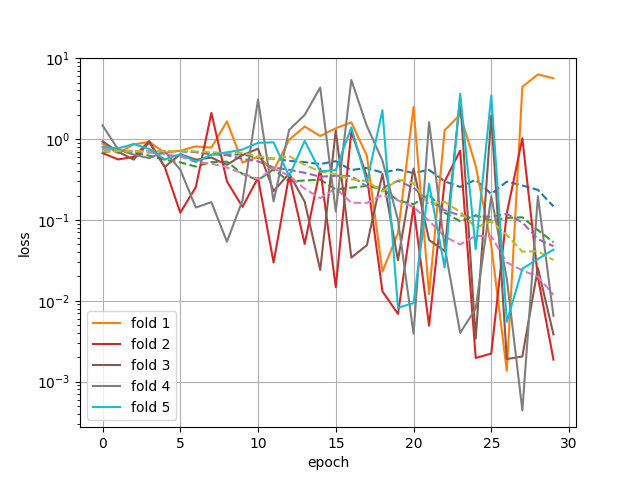

Text(0, 0.5, 'loss')

In [9]:
plt.figure()
for fold in range(len(history_folds)):
    plt.plot(history_folds[fold]['loss'], '--')
    plt.plot(history_folds[fold]['val_loss'], label='fold {}'.format(fold+1))
plt.yscale('log')
plt.legend()
plt.grid('on')
plt.xlabel('epoch')
plt.ylabel('loss')

## Retrain ensemble on all training set

In [10]:
%%time
generator = batch_generator(df, batch_size)
steps = int(np.ceil(len(df)/batch_size))
    
ensemble_models = []

for e in range(n_ensembles):
    print("Ensemble", e+1)
    model = get_model()
    model.fit(generator,
              steps_per_epoch=steps,
              epochs=epochs,
              verbose=0,
              class_weight=dict(enumerate(class_weights)))
    ensemble_models.append(model)

Ensemble 1
Ensemble 2
Ensemble 3
Ensemble 4
Ensemble 5
Ensemble 6
Ensemble 7
Ensemble 8
Ensemble 9
Ensemble 10
CPU times: user 9min 27s, sys: 9min 43s, total: 19min 11s
Wall time: 19min 14s


# Predict test set

In [11]:
# get filenames of test set samples
filenames_test = sorted(test_dir.glob("*.npy"))
for filename in filenames_test:
    assert filename.is_file(), filename
    
# get features 
features_test = [np.load(f)[:,3:] for f in filenames_test]

In [12]:
# get predictions of all trained models in the ensemble
ensemble_prediction = [[model.predict(feature[None,...])[0] for feature in features_test] for model in ensemble_models]
ensemble_prediction = np.stack(ensemble_prediction, axis=0)

<IPython.core.display.Javascript object>


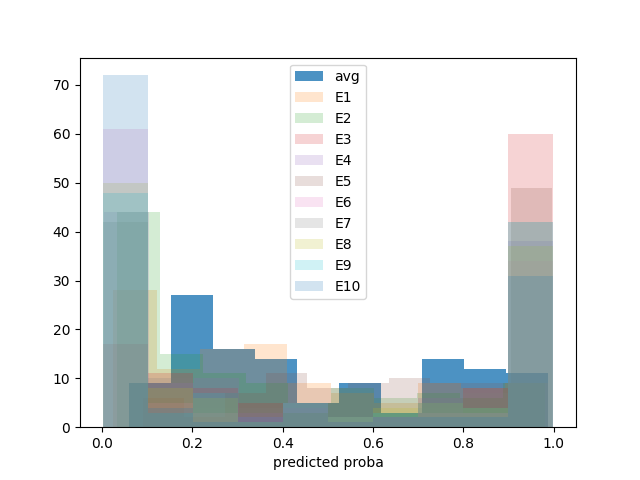

Text(0.5, 0, 'predicted proba')

In [13]:
plt.figure()
_=plt.hist(ensemble_prediction.mean(axis=0), alpha=0.8, label='avg')
for e in range(ensemble_prediction.shape[0]):
    _=plt.hist(ensemble_prediction[e], alpha=0.2, label="E{}".format(e+1))
plt.legend()
plt.xlabel('predicted proba')

In [14]:
# extract image IDs from filenames
ids = [re.search("ID_(.+?).npy", str(filename)).group(1) for filename in filenames_test]

# populate DF with IDs and predictions as average vote of ensembles
df_test = pd.DataFrame({'ID':ids, 'Target':  ensemble_prediction.mean(axis=0).flatten()})
df_test.set_index("ID", inplace=True)
df_test.to_csv(data_dir / "preds_test_chowder_E{}.csv".format(n_ensembles))